##$ Different meshes are available when solving the diffusion or any other PDE

For a 1D system, the diffusional flux is defined as

$ J = -D \frac{\partial x}{\partial z} $

**Cartesian**

$ \frac{\partial x}{\partial t} = -\frac{\partial}{\partial z} (J) $

**Cylindrical**

$ \frac{\partial x}{\partial t} = - \frac{1}{r} \frac{\partial}{\partial r} (r J) $

**Spherical**

$ \frac{\partial x}{\partial t} = - \frac{1}{r^2} \frac{\partial}{\partial r} (r^2 J) $

To show the different meshes, we could create a simple heat transfer model to apply the meshes to and compare to analytical solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kawin.diffusion.mesh import AbstractMesh, DiffusionPair
from kawin.GenericModel import GenericModel

class ThermalModel(GenericModel):
    def __init__(self, mesh: AbstractMesh, k, rho, cp):
        super().__init__()
        self.mesh = mesh
        self.T0 = 298.15
        self.k = k
        self.rho = rho
        self.cp = cp
        self.D = k / rho / cp

        # Assume mesh is in temperature and convert to enthalpy
        # Since self.mesh.y could be in any shape, we want to flatten it to (N,1)
        T = self.mesh.flattenResponse(self.mesh.y)
        H = self.rho * self.cp * (T - self.T0)
        self.mesh.y = self.mesh.unflattenResponse(H)

    def getCurrentX(self):
        return [self.mesh.flattenResponse(self.mesh.y)]
    
    def getDt(self, dxdt):
        return 0.4*self.mesh.dz**2 / self.D / self.mesh.dims
    
    def getdXdt(self, t, x):
        H_d, z_d = self.mesh.getDiffusivityCoordinates(x[0])
        ks = self.k*np.ones(H_d.shape)
        H_r, z = self.mesh.getResponseCoordinates(x[0])
        T_r = self._enthalpyToTemp(H_r)
        return [self.mesh.computedXdt([DiffusionPair(diffusivity=ks, response=T_r)])]
    
    def postProcess(self, time, x):
        super().postProcess(time, x)
        self.mesh.y = self.mesh.unflattenResponse(x[0])
        return self.getCurrentX(), False
    
    def _enthalpyToTemp(self, H):
        return H/self.rho/self.cp + self.T0
    
    @property
    def z(self):
        return self.mesh.z
    
    @property
    def T(self):
        H = self.mesh.flattenResponse(self.mesh.y)
        return self.mesh.unflattenResponse(self._enthalpyToTemp(H))
    

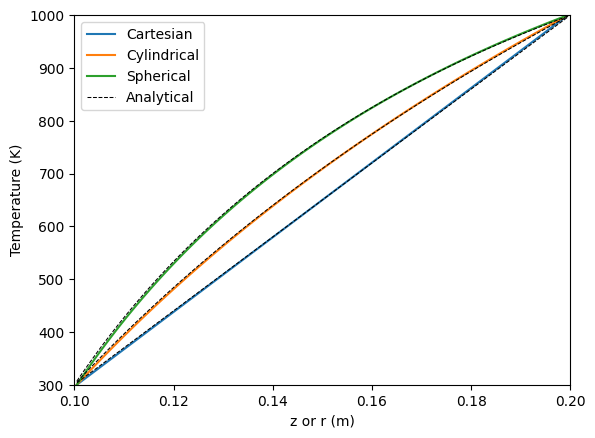

In [34]:
from kawin.diffusion.mesh import Cartesian1D, Cylindrical1D, Spherical1D
from kawin.diffusion.mesh import MixedBoundary1D, ProfileBuilder, ConstantProfile

xlim = [0.1, 0.2]
ylim = [300, 1000]
N = 100
responses = ['T']
k = 13 # W/m-K
rho = 7870 # kg/m3
cp = 490 # J/kg-K


# Dirichlet boundary conditions on ends of mesh
bc = MixedBoundary1D(responses)
bc.setLBC('T', 'dirichlet', ylim[0])
bc.setRBC('T', 'dirichlet', ylim[1])

profile = ProfileBuilder()
profile.addBuildStep(ConstantProfile(ylim[0]), 'T')

meshCartesian = Cartesian1D(responses, xlim, N)
meshCylindrical = Cylindrical1D(responses, xlim, N)
meshSpherical = Spherical1D(responses, xlim, N)
meshes = [meshCartesian, meshCylindrical, meshSpherical]
labels = ['Cartesian', 'Cylindrical', 'Spherical']
for i, mesh in enumerate(meshes):
    mesh.setResponseProfile(profile, bc)
    model = ThermalModel(mesh, k=k, rho=rho, cp=cp)
    model.solve(3600)
    plt.plot(model.z, model.T, label=labels[i])

# Solution for cartesian: x = A*z + B
# Solution for cylindrical: x = A*ln(r) + B
# Solution for spherical: x = A/r + B
A = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])
B = ylim[0] - A*xlim[0]
cart_ideal = A*meshCartesian.z + B

A = (ylim[1] - ylim[0]) / np.log(xlim[1] / xlim[0])
B = ylim[0] - A*np.log(xlim[0])
cyl_ideal = A*np.log(meshCylindrical.z) + B

A = (ylim[1] - ylim[0]) / (1/xlim[1] - 1/xlim[0])
B = ylim[0] - A/xlim[0]
sph_ideal = A/meshSpherical.z + B
plt.plot(meshCartesian.z, cart_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.plot(meshCylindrical.z, cyl_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.plot(meshSpherical.z, sph_ideal, color='k', linestyle='--', linewidth=0.75, label='Analytical')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('z or r (m)')
plt.ylabel('Temperature (K)')
plt.legend(labels=labels+['Analytical'])
plt.show()

Periodic boundary conditions are also available, but is only valid for cartesian meshes

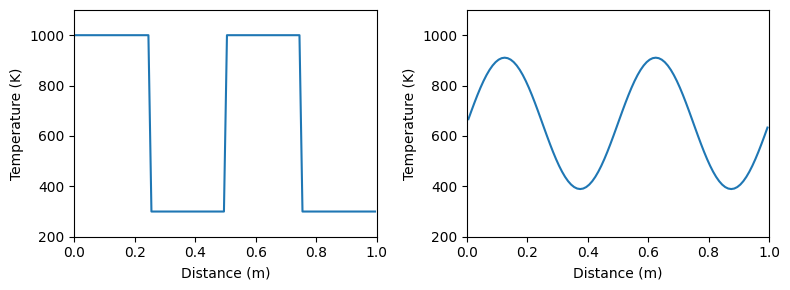

In [ ]:
from kawin.diffusion.mesh import PeriodicBoundary1D, BoundedRectangleProfile

profile = ProfileBuilder()
profile.addBuildStep(ConstantProfile(300))
profile.addBuildStep(BoundedRectangleProfile(0, 0.25, 700, 0))
profile.addBuildStep(BoundedRectangleProfile(0.5, 0.75, 700, 0))

pb = PeriodicBoundary1D()
mesh = Cartesian1D(responses=['T'], zlim=[0,1], N=100)
mesh.setResponseProfile(profile, pb)

model = ThermalModel(mesh, k=k, rho=rho, cp=cp)

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(model.z, model.T)
ax[0].set_xlim([0,1])
ax[0].set_ylim([200, 1100])

model.solve(1000)
ax[1].plot(model.z, model.T)

for i in range(2):
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([200, 1100])
    ax[i].set_xlabel('Distance (m)')
    ax[i].set_ylabel('Temperature (K)')
fig.tight_layout()
plt.show()